In [45]:
from google.colab import files
import io
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

import missingno as msno
import seaborn as sns 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## File Upload and Data Read

In [46]:
uploaded = files.upload()

Saving county_statistics.csv to county_statistics (1).csv


In [47]:
data = pd.read_csv(io.BytesIO(uploaded['county_statistics.csv']))
data.shape

(4867, 51)

## Data Preprocessing

In [48]:
## Prepare data by getting rid of missing values and features we don't want to use.

# Drop useless entries (no covid data, 2016 data, some missing labels)
data = data[:3111]

# Drop 2016 results, too powerful to use.
data = data.drop(['percentage16_Donald_Trump', 'percentage16_Hillary_Clinton', 'total_votes16', 'votes16_Donald_Trump', 'votes16_Hillary_Clinton'],  axis=1)

# Drop ID column
data = data.drop(data.columns[0], axis=1)

# Drop county name, this doesn't really matter for now.
data = data.drop('county', axis=1)

# Drop rows with any NaN in the label column. Now have about ~3k useable counties left.
data = data.dropna(how='any', subset=['percentage20_Donald_Trump'])

# Drop rows with any NaN in the lat, long, cases, deaths columns. There are about 40 of these.
data = data.dropna(how='any', subset=['lat'])

In [49]:
# Analyze data
print(data.shape)
print(data.corr())
print(data.info())

(3046, 44)
                           percentage20_Donald_Trump  ...  Unemployment
percentage20_Donald_Trump                   1.000000  ...     -0.247929
percentage20_Joe_Biden                     -0.998737  ...      0.259341
total_votes20                              -0.367498  ...      0.019033
votes20_Donald_Trump                       -0.323640  ...      0.010544
votes20_Joe_Biden                          -0.376017  ...      0.023619
lat                                        -0.051809  ...     -0.346312
long                                       -0.066365  ...      0.150249
cases                                      -0.314356  ...      0.040270
deaths                                     -0.303381  ...      0.059749
TotalPop                                   -0.367433  ...      0.033868
Men                                        -0.365848  ...      0.033168
Women                                      -0.368878  ...      0.034536
Hispanic                                   -0.145601 

In [50]:
# One hot encode the State column
data.dtypes
data = pd.get_dummies(data)

In [51]:
# Ensure no missing values
# msno.matrix(data);

In [52]:
# Split label
trump = data['percentage20_Donald_Trump']

# Remove all other 2020 voting info
data = data.drop(['percentage20_Donald_Trump', 'percentage20_Joe_Biden', 'votes20_Donald_Trump', 'votes20_Joe_Biden'],  axis=1)

In [53]:
trump.head()

0    0.661
1    0.795
2    0.542
3    0.504
4    0.697
Name: percentage20_Donald_Trump, dtype: float64

In [54]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split( data, trump, test_size=0.33)

In [55]:
y_train.shape
y_train.head(30)

637     0.823
458     0.855
1470    0.507
3044    0.338
2475    0.368
1239    0.596
2029    0.676
1871    0.251
1092    0.745
832     0.872
2978    0.379
391     0.637
2334    0.740
924     0.506
749     0.447
591     0.707
1733    0.547
1803    0.742
149     0.424
800     0.368
2129    0.150
684     0.569
1409    0.279
1158    0.769
352     0.796
1237    0.393
1210    0.744
494     0.402
1605    0.592
1275    0.357
Name: percentage20_Donald_Trump, dtype: float64

## Model Creation

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

### Random Forest

In [57]:
rf = RandomForestRegressor(random_state=0)

Feature: 0 total_votes20, Score: 0.01331
Feature: 1 lat, Score: 0.04616
Feature: 2 long, Score: 0.03741
Feature: 3 cases, Score: 0.00656
Feature: 4 deaths, Score: 0.00341
Feature: 5 TotalPop, Score: 0.00799
Feature: 6 Men, Score: 0.01214
Feature: 7 Women, Score: 0.00652
Feature: 8 Hispanic, Score: 0.00927
Feature: 9 White, Score: 0.16183
Feature: 10 Black, Score: 0.08421
Feature: 11 Native, Score: 0.00378
Feature: 12 Asian, Score: 0.09331
Feature: 13 Pacific, Score: 0.00095
Feature: 14 VotingAgeCitizen, Score: 0.01431
Feature: 15 Income, Score: 0.00981
Feature: 16 IncomeErr, Score: 0.00637
Feature: 17 IncomePerCap, Score: 0.01452
Feature: 18 IncomePerCapErr, Score: 0.00679
Feature: 19 Poverty, Score: 0.00439
Feature: 20 ChildPoverty, Score: 0.00382
Feature: 21 Professional, Score: 0.01357
Feature: 22 Service, Score: 0.00965
Feature: 23 Office, Score: 0.00695
Feature: 24 Construction, Score: 0.06493
Feature: 25 Production, Score: 0.02464
Feature: 26 Drive, Score: 0.02052
Feature: 27 Car

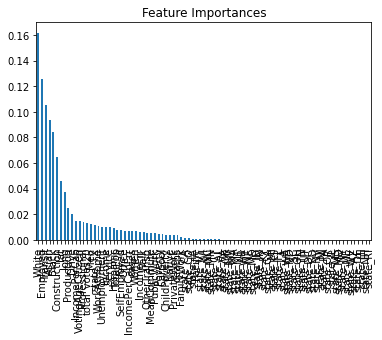

In [58]:
rf.fit(X_train, y_train)

# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d %s, Score: %.5f' % (i,data.columns[i] ,v))
# plot feature importance
# plot feature importance
feat_imp = pd.Series(rf.feature_importances_, data.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [59]:
results = rf.predict(X_test)

In [60]:
preds = pd.DataFrame(data=results)

In [61]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, preds)

0.004025475943539993

In [62]:
mean_absolute_error(y_test, preds)

0.045862563507841826

MAE: 0.04532185884691847

MSE: 0.0038097501566759905

### Decision Tree

Feature: 0 total_votes20, Score: 0.02726
Feature: 1 lat, Score: 0.04189
Feature: 2 long, Score: 0.05397
Feature: 3 cases, Score: 0.00943
Feature: 4 deaths, Score: 0.00410
Feature: 5 TotalPop, Score: 0.00172
Feature: 6 Men, Score: 0.00082
Feature: 7 Women, Score: 0.00604
Feature: 8 Hispanic, Score: 0.01218
Feature: 9 White, Score: 0.21785
Feature: 10 Black, Score: 0.01491
Feature: 11 Native, Score: 0.00382
Feature: 12 Asian, Score: 0.00474
Feature: 13 Pacific, Score: 0.00019
Feature: 14 VotingAgeCitizen, Score: 0.00078
Feature: 15 Income, Score: 0.00451
Feature: 16 IncomeErr, Score: 0.00901
Feature: 17 IncomePerCap, Score: 0.01483
Feature: 18 IncomePerCapErr, Score: 0.00442
Feature: 19 Poverty, Score: 0.00311
Feature: 20 ChildPoverty, Score: 0.00569
Feature: 21 Professional, Score: 0.00855
Feature: 22 Service, Score: 0.00380
Feature: 23 Office, Score: 0.00544
Feature: 24 Construction, Score: 0.06785
Feature: 25 Production, Score: 0.01711
Feature: 26 Drive, Score: 0.01424
Feature: 27 Car

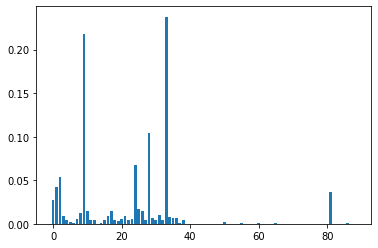

In [63]:
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train)



# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d %s, Score: %.5f' % (i,data.columns[i] ,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [64]:
mean_squared_error(y_test,model.predict(X_test))

0.009833967196819086

In [65]:
mean_absolute_error(y_test, model.predict(X_test))

0.06940258449304175

MAE: 0.07071570576540756

MSE: 0.009379811133200796

### Gradient Boosting

In [66]:
gb = GradientBoostingRegressor(random_state=0)
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [67]:
mean_squared_error(y_test, gb.predict(X_test))

0.0038191852397122202

In [68]:
mean_absolute_error(y_test, gb.predict(X_test))

0.04577212351486584

**MAE: 0.04507312175422129**

MSE: 0.0036663746006385853

### Ridge Regression

In [69]:
ridge = linear_model.Ridge(alpha=.5)
ridge.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [70]:
mean_squared_error(y_test, ridge.predict(X_test))

0.004041197293093393

In [71]:
mean_absolute_error(y_test, ridge.predict(X_test))

0.046140396595393984

MAE: 0.048954747031466114

MSE: 0.004290868804295695

## Results of Initial Predictions

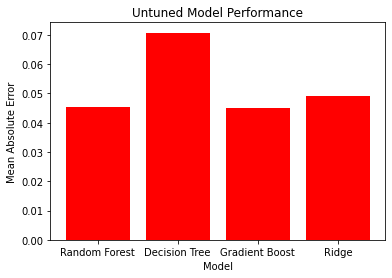

In [72]:
models = ['Random Forest', 'Decision Tree', 'Gradient Boost', 'Ridge']
maes = [0.0453, 0.07072, 0.0451, 0.0490]

plt.bar(models, maes, color='red')
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.title("Untuned Model Performance")
plt.show()


# Narrowing down to COVID Data
I wanted to look at more directly related COVID data, choosing small subset of features here. 

I first tried just using total votes, cases, deaths, total pop, unemployment rate and state data but this was too heavily favoring the TotalPop and TotalVotes columns as they indicate a strong trend.

I then tried to narrow it down more by creating per capita columns and removing the flat population amounts. I also dropped the state information. This forced the models to exclusively use COVID trends in the counties rather than just whether the county was large or small.

In [73]:
# Remove most features
covid_data = data.drop(['FamilyWork', 'SelfEmployed', 'PublicWork', 'PrivateWork', 'Employed', 'MeanCommute', 'WorkAtHome', 'OtherTransp', 'Walk', 'Transit', 'Carpool', 'Drive', 'Production', 'Construction', 'Office', 'Service', 'Professional', 'ChildPoverty', 'Poverty', 'IncomePerCapErr', 'IncomePerCap', 'IncomeErr', 'Income', 'VotingAgeCitizen', 'Pacific', 'Asian', 'Native', 'Black', 'White', 'Hispanic', 'Women', 'Men', 'lat', 'long'],  axis=1)

In [74]:
# Now it's just the state info, unemployment rate, cases, deaths and total amount of votes
covid_data.head(30)

,total_votes20,cases,deaths,TotalPop,Unemployment,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,12433.0,805.0,17.0,24788.0,9.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,28425.0,3182.0,102.0,62607.0,8.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16938.0,1227.0,19.0,32840.0,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,259389.0,17451.0,181.0,435117.0,4.3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4183.0,222.0,1.0,7192.0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,8766.0,517.0,22.0,19304.0,6.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10337.0,578.0,0.0,25437.0,5.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,7108.0,855.0,11.0,22136.0,5.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,234599.0,15538.0,263.0,487850.0,5.1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2158.0,87.0,1.0,3785.0,4.2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


After running the model on the dataset as above I was getting about a ~.01 MSE. Total population and unemployment rate became very important. Amount of COVID cases and deaths were also used a lot more. 

Now I want to try not even using the total population as it is a pretty powerful indicator (big counties tend to lean Biden). Still want to capture COVID cases relative to population so going to create a new feature for that.

In [75]:
# Create new features to capture COVID data per capita
covid_data["cases_per_pop"] = covid_data['cases'] / covid_data['TotalPop'] 
covid_data['death_per_pop'] = covid_data['deaths'] / covid_data['TotalPop']

In [76]:
# Drop old population related stats and flat covid
covid_data = covid_data.drop(['TotalPop', 'total_votes20', 'cases', 'deaths'], axis=1)

In [77]:
# Drop state data
covid_data = covid_data.drop(covid_data.iloc[:, 1:51], axis=1)

Now the dataset is just unemployment rate, cases per capita and death per capita. Exclusively using percentages here, no flat information.

In [78]:
covid_data.head()

,Unemployment,cases_per_pop,death_per_pop
0,9.4,0.032475,0.000686
1,8.9,0.050825,0.001629
2,5.4,0.037363,0.000579
3,4.3,0.040106,0.000416
4,3.0,0.030868,0.000139


### Model CV, Random Search, Tuning

Tuning a Random Forest using Random Search, Grid Search and Cross validation

In [79]:
# Tuning, Random Search, Grid Search

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

param_grid = {'n_estimators': n_estimators}

rf = RandomForestRegressor(random_state=0, min_samples_split= 10, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 10, bootstrap= True)

# Grid Search
# rf_grid = GridSearchCV(rf, param_grid = param_grid, cv = 4, verbose = True, n_jobs = -1, scoring="neg_mean_squared_error")
# best_rf_grid = rf_grid.fit(covid_data, trump)

# Random Search
# rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 4, verbose = True, n_jobs = -1, scoring="neg_mean_squared_error")
# best_rf_rnd = rf_rnd.fit(covid_data,trump)


In [80]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score (MSE): ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

# clf_performance(best_rf_rnd,'Random Forest Regressor Random')
# clf_performance(best_rf_grid,'Random Forest Regressor Grid')

In [81]:
# scores = cross_val_score(rf_cv, covid_data, trump, cv=10, scoring="neg_mean_absolute_error")
# print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

### Manual Train Test Split

Feature: 0 Unemployment, Score: 0.38398
Feature: 1 cases_per_pop, Score: 0.29795
Feature: 2 death_per_pop, Score: 0.31806


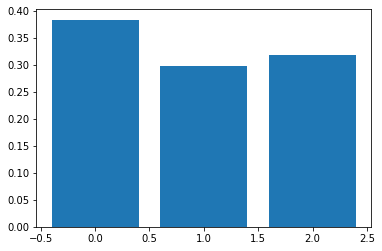

In [82]:
rf = RandomForestRegressor(random_state=0, n_estimators= 1800, min_samples_split= 10, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 10, bootstrap= True)

X_train, X_test, y_train, y_test = train_test_split(covid_data, trump, test_size=0.33)

rf.fit(X_train, y_train)

# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d %s, Score: %.5f' % (i,covid_data.columns[i] ,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [83]:
from sklearn.metrics import mean_absolute_error

preds = rf.predict(X_test)
mean_absolute_error(y_test,preds)

0.11564270677266646

Getting ~.0246 MSE and .1245 MAE with zero tuning performed. Just using death_per_capita, cases_per_capita and unemployment rate.

After some initial random search tuning, got to .111 MAE


### Gradient Boost
Out of the box, GBoost seems to be better than Random Forest for COVID stats

In [84]:
from sklearn.ensemble import GradientBoostingRegressor

In [85]:
gb = GradientBoostingRegressor(random_state=0)

In [86]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [87]:
preds = gb.predict(X_test)
mean_squared_error(y_test,preds)

0.021509317092116273

In [88]:
covid_data = covid_data.drop(['death_per_pop', 'cases_per_pop'], axis=1)

scores = cross_val_score(gb, covid_data, trump, cv=10, scoring="neg_mean_absolute_error")

print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

Accuracy: -0.12076 (+/- 0.00610)


In [89]:
import matplotlib.pylab as plt

# get importance
importance = gb.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d %s, Score: %.5f' % (i,covid_data.columns[i] ,v))
# plot feature importance
feat_imp = pd.Series(gb.feature_importances_, covid_data.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

Feature: 0 Unemployment, Score: 0.35519


IndexError: ignored

In [ ]:
trump.head()

In [ ]:
## See how well it did at predicting who won correctly using threshold 50%

# Convert real labels to 
def winner(x):
  return True if x > .50 else False

y_test_won = y_test.apply(winner)
y_pred_won = pd.Series(preds).apply(winner)


In [ ]:
y_pred_won.head()

In [ ]:
import numpy as np
a = np.array(y_pred_won)
b = np.array(y_test_won)
error = np.mean( a != b )
error


### Ada Boost

In [90]:
from sklearn.ensemble import AdaBoostRegressor

In [91]:
ada = AdaBoostRegressor(random_state=0, loss="linear")
ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=0)

In [ ]:
preds = ada.predict(X_test)
mean_absolute_error(y_test,preds)

In [92]:
scores = cross_val_score(ada, covid_data, trump, cv=10, scoring="neg_mean_absolute_error")

print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.12713 (+/- 0.01031)


### Gradient Descent



In [93]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


SGD = SGDRegressor()
pipeline = make_pipeline(StandardScaler(),SGD)



scores = cross_val_score(pipeline, covid_data, trump, cv=10, scoring="neg_mean_absolute_error")

print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.12074 (+/- 0.01085)


### Support Vector Machines

In [94]:
from sklearn import svm

svm = svm.SVR()

scores = cross_val_score(svm, covid_data, trump, cv=10, scoring="neg_mean_absolute_error")
print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.11810 (+/- 0.01235)


### Ridge

In [95]:
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=.5)

scores = cross_val_score(ridge, covid_data, trump, cv=10, scoring="neg_mean_absolute_error")
print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.12075 (+/- 0.01088)


### KNearestNeighbors

In [96]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=2)
scores = cross_val_score(neigh, covid_data, trump, cv=10, scoring="neg_mean_absolute_error")
print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.14467 (+/- 0.01530)


### COVID models results

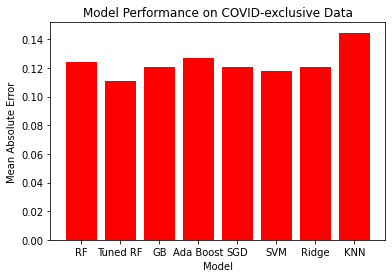

In [104]:
models = ["RF", "Tuned RF", "GB", "Ada Boost", "SGD", "SVM", "Ridge", "KNN"]
maes = [.1245, .111, 0.12076, 0.12713, 0.12074, 0.11810,0.12075, 0.14467]

plt.bar(models, maes, color='red')
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.title("Model Performance on COVID-exclusive Data")
plt.show()